# Naver Shopping Review Sentiment Analysis
- https://wikidocs.net/94600

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load dataset

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fe1ca1150f0>)

In [3]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))
total_data[:5]

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


전체 리뷰 개수 : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## Text Preprocessing

In [5]:
total_data["label"] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
len(total_data["ratings"].unique()), len(total_data["reviews"].unique()), len(total_data["label"].unique())

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=["reviews"], inplace=True)
print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 199908


In [11]:
total_data.isnull().values.any()

False

### Split train/test set

In [12]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=0)
len(train_data), len(test_data)

(149931, 49977)

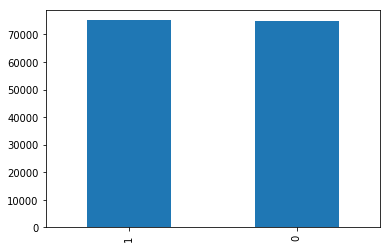

In [13]:
train_data['label'].value_counts().plot(kind = 'bar')

In [14]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74843
1      1  75088


### 한글과 공백을 남기고 삭제하기

In [15]:
def remove_all_except_korean_and_spaces(df, text_col):
    # 중복 제거
    df.drop_duplicates(subset=[text_col], inplace=True)
    
    # 한글과 공백을 제외한 다른 문자들 제거
    df[text_col] = df[text_col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df[text_col].replace("", np.nan, inplace=True)
    
    # Null 값 제거
    df = df.dropna(how="any")
    
    print(f"샘플의 수: {len(df)}")
    return df

In [18]:
train_data = remove_all_except_korean_and_spaces(train_data, "reviews")

샘플의 수: 149613


In [19]:
test_data = remove_all_except_korean_and_spaces(test_data, "reviews")

샘플의 수: 49927


### Tokenize

In [ ]:
mocab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

In [21]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
len(stopwords)

23

In [ ]:
train_data["tokenized"] = train_data["reviews"].apply(mecab.morphs)
train_data["tokenized"] = train_data["tokenized"].apply(lambda x: [item for item in x if item not in stopwords])

test_data["tokenized"] = test_data["reviews"].apply(mecab.morphs)
test_data["tokenized"] = test_data["tokenized"].apply(lambda x: [item for item in x if item not in stopwords])
train_data[:5]

### Analysis - Word distribution by positive/negative

In [22]:
negative_words = np.hstack(train_data[train_data.label == 0]["tokenized"].values)
positive_words = np.hstack(train_data[train_data.label == 1]["tokenized"].values)

negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)

print(f"부정 리뷰: {negative_word_count.most_common(20)}")
print(f"긍정 리뷰: {positive_word_count.most_common(20)}")

SyntaxError: invalid syntax (<ipython-input-22-ed986efe18af>, line 1)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### 정수 인코딩

In [ ]:
x_train = train_data["tokenized"].values
y_train = train_data["label"].values
x_test = test_data["tokenized"].values
y_test = test_data["label"].values
x_train.shape, y_train.shape, x_test.shape, y_test.shape